In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.rnn as rnn

In [0]:
def unfold(data, n_outputs):
  data = data.reshape(-1)
  y = []
  z = []
  for i in range(0, len(data), n_outputs):
    y.append(data[i])
    z.append(data[i+1])
  return y,z
def transData(data):
  return data.transpose((1,0,2))
def trans(dataY, dataZ):
  dataY = dataY.transpose((0,2,1))
  dataZ = dataZ.transpose((0,2,1))
  return dataY, dataZ

In [0]:
class Generator(object):  
    def __init__(self, funcY, funcZ, predict: int = 50, samples: int = 100, min: float = -30, max: float = 30):
      #max *= np.pi*2
      step = (max-min)/(samples+predict)
      t = np.float32(np.arange(min, max, step))
      y = np.float32(funcY(t))
      z = np.float32(funcZ(t))
      #normalize
      y = self.normalize(y)
      z = self.normalize(z)

      #train set
      self.t = t[0:samples]
      self.y = y[0:samples]
      self.z = z[0:samples]
      self.data = []
      for i in range(0, samples):
        self.data.append(y[i])
      #  self.data.append(z[i])
      self.data = np.asarray(self.data)
      #test set
      self.ft = t[samples:samples+predict]
      self.fy = y[samples:samples+predict]
      self.fz = z[samples:samples+predict]
      
      self.batch_id = 0
      
    #normalization func
    def normalize(self, t):
      out = []
      for i in range(len(t)):
        out.append((t[i] - min(t))/(max(t)-min(t)))
      return np.asarray(out)
    
    """
    As a train data function provided two sets of data, first and next
    e.g.
    current_data = [1,2,3,4,5],[2,3,4,5,6]
    next_data = [2,3,4,5,6],[3,4,5,6,7]
  
    
    def getTrainData(self, steps, inputs, outputs, f_horizon):
      current_data = []
      next_data = []
      while True:
        current_d, next_d = self.next(steps, inputs, outputs, f_horizon)
        current_data += current_d
        next_data += next_d
        if self.batch_id == 0:
          break
      return current_data, next_data
      """
    """
    get the last steps of data
    """
    def getTestData(self, steps, inputs):   
      return self.data[-steps*inputs:].reshape(-1,steps,inputs)
    
    def next(self, steps, inputs, outputs, f_horizon):
      current_data = self.data[self.batch_id : self.batch_id + steps*inputs].reshape((-1, steps, inputs))
      next_data = self.data[self.batch_id + f_horizon*outputs : self.batch_id + steps*outputs + f_horizon*outputs].reshape((-1, steps, outputs))
      self.batch_id += f_horizon*outputs
      if(len(self.data) < self.batch_id + f_horizon + steps*max(inputs, outputs)):
        self.batch_id = 0
      return current_data, next_data

In [0]:
#network param
steps = 40 #liczba punktow przekazana w jednym kroku przewidywania
n_prediction = 40 #liczba punktow do przewidzenia
n_samples = 100 #liczba argumentow
n_inputs = 1 #liczba danych wejsciowych
n_outputs = 1 #liczba danych wyj musi sie rownac n_inputs
n_layers = 2 #deep neural network layers
f_horizon = 1 #liczba wartosci przewidywanych w przod
n_iterations = 50 #lizba iteracj - ograncizenie, jesli precyzja nie zostanie osiagnieta
learning_rate = 0.001 #NIE TYKAC
n_hidden_units = 900 #liczba wezlow ukrytych sieci neuronowej
display_steps = 1 #nie tykac
precision = 2 #duzo tykac; do ograniczania overfeeding 

In [0]:
tf.reset_default_graph()
# None, steps, n_inputs/n_outputs
inputs = tf.placeholder(tf.float32, [None, steps, n_inputs])
outputs = tf.placeholder(tf.float32, [None, steps, n_outputs])

lstm_cells = [rnn.LSTMCell(num_units = n_hidden_units, forget_bias = 1.0, activation = tf.nn.leaky_relu) for _ in range(n_layers)]
stacked_lstm = rnn.MultiRNNCell(lstm_cells)
rnn_output, states = tf.nn.dynamic_rnn(cell = stacked_lstm, inputs = inputs, dtype=tf.float32)
# -1, steps, n_hidden_units
stacked_rnn_output = tf.reshape(rnn_output, [-1, steps, n_hidden_units])
stacked_outputs = tf.layers.dense(stacked_rnn_output, n_outputs)
# -1, steps, n_outputs
output = tf.reshape(stacked_outputs, [-1, steps, n_outputs])

cost = tf.reduce_mean(tf.reduce_sum(tf.square(output - outputs)))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(cost)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

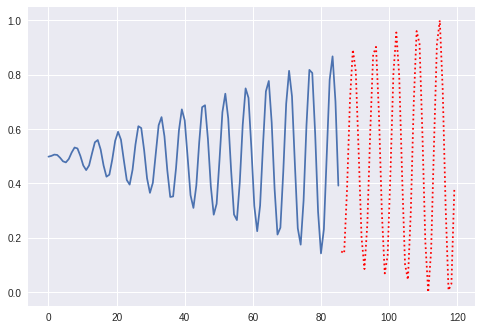

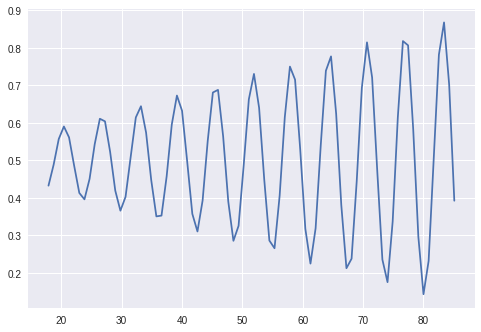

In [48]:
def funcY(x):
  return np.sin(x)*x #funckja y
def funcZ(x):
  return -x + 8 #funkcja z
#generate data
generator = Generator(funcY = funcY, funcZ = funcZ, predict = n_prediction*f_horizon, samples = n_samples + f_horizon,  min = 0.0, max = 120.0) #min x, max x
#show data
plt.plot(generator.t, generator.y)
plt.plot(generator.ft, generator.fy, color='red', linestyle=':')
plt.show()
"""
plt.plot(generator.t, generator.z)
plt.plot(generator.ft, generator.fz, color='red', linestyle=':')
plt.show()
"""
#generate test data
test_data = generator.getTestData(steps = steps, inputs = n_inputs)
#test_y , test_z = unfold(test_data, n_outputs)
test_y = test_data.reshape(-1)
plt.plot(generator.t[-len(test_y):], test_y)
plt.show();
#plt.plot(generator.t[-len(test_z):], test_z)
#plt.show();

#generate train data
#current_data, next_data = generator.getTrainData(steps = steps, inputs = n_inputs, outputs = n_outputs, f_horizon = f_horizon)
#current_data, next_data = generator.next(steps = steps, inputs = n_inputs, outputs = n_outputs, f_horizon = f_horizon)
#print(current_data, next_data)
#print(current_data.shape)

0 	MSE: 121.1272234916687
1 	MSE: 50.08424913883209
2 	MSE: 53.31527507305145
3 	MSE: 50.21303856372833
4 	MSE: 49.28130125999451
5 	MSE: 46.158238768577576
6 	MSE: 44.738224029541016
7 	MSE: 42.96192145347595
8 	MSE: 1106026.449805975
9 	MSE: 37.163368582725525
10 	MSE: 36.863677740097046
11 	MSE: 36.92930054664612
12 	MSE: 36.555724024772644
13 	MSE: 35.851704716682434
14 	MSE: 33.00314021110535
15 	MSE: 19.47047182917595
16 	MSE: 9.515763811767101
17 	MSE: 6.459107667207718
18 	MSE: 6.268029570579529
19 	MSE: 4.934938579797745
20 	MSE: 4.273914717137814
21 	MSE: 3.8489397354424
22 	MSE: 3.910546489059925
23 	MSE: 4.1535365507006645
24 	MSE: 2.9113901033997536
25 	MSE: 3.1568323373794556
26 	MSE: 3.6721833422780037
27 	MSE: 3.4345764219760895
28 	MSE: 3.9162316266447306
29 	MSE: 2.7667260468006134
30 	MSE: 3.1742319595068693
31 	MSE: 3.5180195197463036
32 	MSE: 2.52132211253047
33 	MSE: 2.7741958294063807
34 	MSE: 2.079866861924529
35 	MSE: 1.9232671707868576


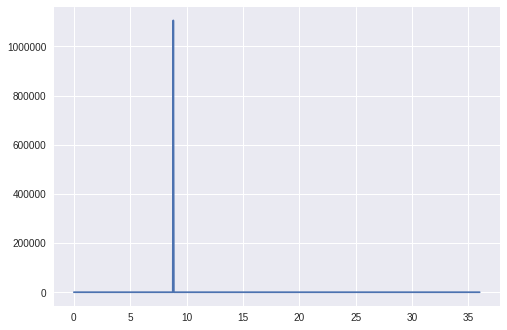

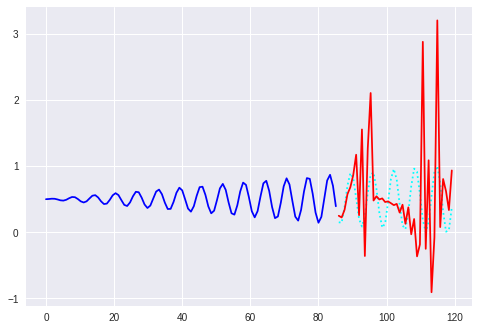

steps: 	 80
n_prediction: 	 40
n_samples: 	 100
n_inputs: 	 1
n_outputs: 	 1
n_layers: 	 2
f_horizon: 	 1
n_iteration: 	 50
learing_rate: 	 0.001
n_hidden_units:	 900
display_steps: 	 1
precision: 	 2


In [49]:
with tf.Session() as sess:
  init.run()
  i = 0
  mse = precision
  mse_graph = []
  while i < n_iterations and mse >= precision:
    mse = 0
    while True:
      current_data, next_data = generator.next(steps = steps, inputs = n_inputs, outputs = n_outputs, f_horizon = f_horizon)
      #current_data, next_data = trans(current_data, next_data)
      sess.run(training_op, feed_dict={inputs: current_data, outputs: next_data})
      mse_b = sess.run(cost, feed_dict={inputs: current_data, outputs: next_data})
      mse_graph.append(mse_b)
      mse += mse_b
      if generator.batch_id == 0:
        break
    
    if i % display_steps == 0:
      print(i,"\tMSE:",mse)
    i += 1
  prediction = []
  for _ in range(0, n_prediction*n_outputs):
    test_data = sess.run(output, feed_dict={inputs: test_data})
    prediction = np.append(prediction, test_data.reshape(-1)[-f_horizon:])
  
  prediction = np.asarray(prediction)
  #y_pred, z_pred = unfold(prediction, n_outputs)
  y_pred = prediction.reshape(-1)
  #MSE graph
  mse_graph = np.asarray(mse_graph)
  plt.plot(np.linspace(0,i,len(mse_graph)),mse_graph)
  plt.show()
  #result graph
  plt.plot(generator.t, generator.y, color='blue')
  plt.plot(generator.ft, generator.fy, color = 'cyan', linestyle = ':')
  plt.plot(generator.ft, y_pred,'r-', color='red')
  plt.show()
  """
  plt.plot(generator.t, generator.z, color='blue')
  plt.plot(generator.ft, generator.fz, color = 'cyan', linestyle = ':')
  plt.plot(generator.ft, z_pred,'r-', color='red')
  plt.show()
  """
  print("steps: \t",steps)
  print("n_prediction: \t", n_prediction)
  print("n_samples: \t", n_samples)
  print("n_inputs: \t", n_inputs)
  print("n_outputs: \t", n_outputs)
  print("n_layers: \t", n_layers)
  print("f_horizon: \t", f_horizon)
  print("n_iteration: \t", n_iterations)
  print("learing_rate: \t", learning_rate)
  print("n_hidden_units:\t", n_hidden_units)
  print("display_steps: \t", display_steps)
  print("precision: \t", precision)